In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch
from tqdm import tqdm

import sys
sys.path.append('../')
from PhaseReductionNet import Encoder, Decoder, LatentSteper

plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 30 

def to_polar(x):
    theta = torch.atan2(x[:, 1], x[:, 0])
    return theta

In [2]:
device = 'cuda'
enc = Encoder(input_dim=20,output_dim=3,hidden_dim = 100)
step = LatentSteper(zd = 1)
dec = Decoder(input_dim=3,output_dim=20,hidden_dim = 100)

model = 'FHNR'
result_dir = f'../out/CO/'

enc.load_state_dict(torch.load(os.path.join(result_dir,'enc.pth')))
step.load_state_dict(torch.load(os.path.join(result_dir,'step.pth')))
dec.load_state_dict(torch.load(os.path.join(result_dir,'dec.pth')))

enc.to(device)
step.to(device)
dec.to(device)

enc.eval()
step.eval()
dec.eval()
print(step.state_dict())
w = step.state_dict()['theta'].item()
print(w)

X0 = np.load(f'../data/limit_cycle_{model}.npy')
Z0 = np.load(f'../data/phase_response_function_{model}.npy')
print(X0.shape)
mean = np.mean(X0,axis=0)
std = np.std(X0,axis=0)
print(mean,std)

OrderedDict([('theta', tensor(0.3161, device='cuda:0')), ('lam', tensor([0.9661], device='cuda:0'))])
0.3160923421382904
(17662, 20)
[ 0.28951054  0.28951054  0.28950974  0.28950865  0.28950732  0.28950566
  0.28950374  0.28950378  0.28950562  0.28950838 -0.46840656 -0.46839715
 -0.46839497 -0.46839407 -0.4683934  -0.46839155 -0.46839502 -0.46841554
 -0.46842173 -0.46842814] [0.29705915 0.29705916 0.29706005 0.29706086 0.29706119 0.2970606
 0.29705852 0.29705857 0.29706056 0.29706098 1.43607456 1.43607314
 1.43607174 1.43607105 1.43607049 1.43606874 1.43607196 1.43606907
 1.43606133 1.43605055]


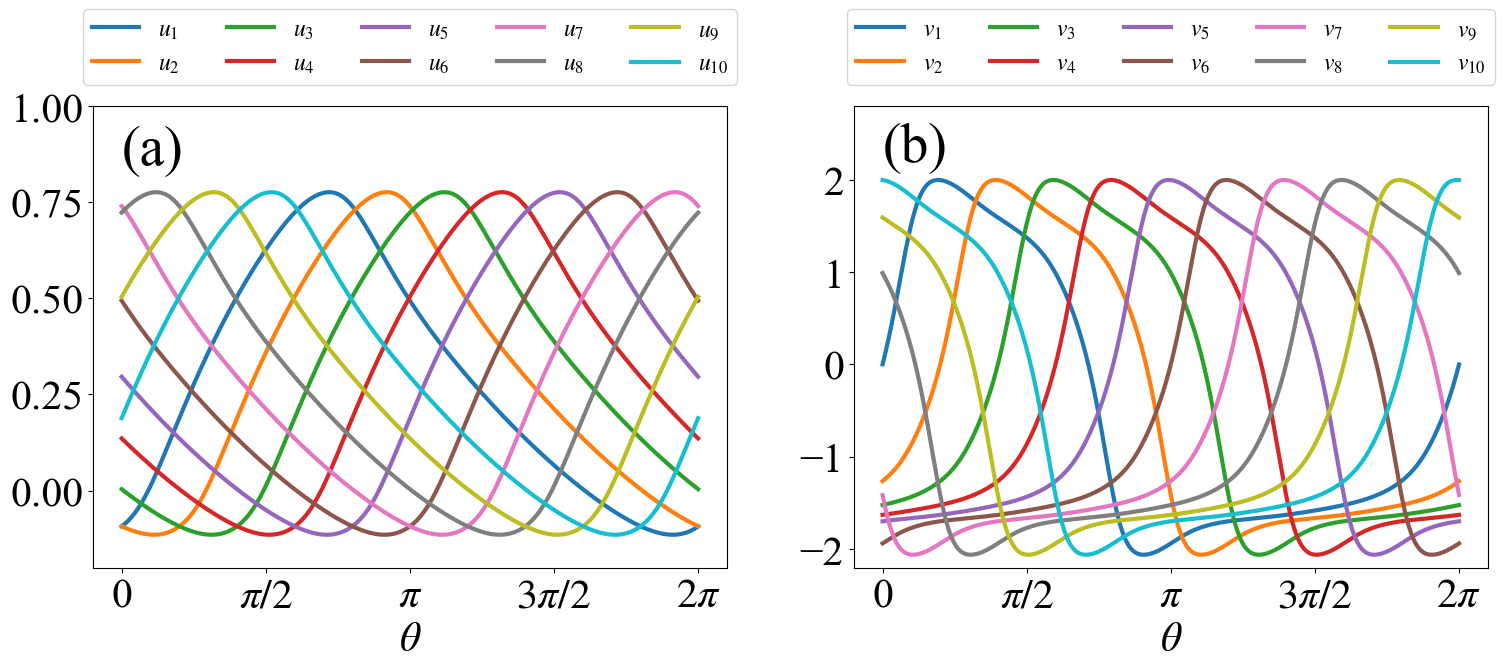

In [3]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,2*np.pi,len(X0)),X0[:,:10],lw=3,label=[rf'$u_{i}$' for i in range(1,10)]+[r'$u_{10}$'])
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
#plt.xlim(-0.5,10)
plt.xlabel(r'$\theta$')
plt.text(0,0.85,'(a)',fontsize=40)
plt.legend(loc="lower center",fontsize=17,ncol=5,bbox_to_anchor=(0.5, 1.02,))
plt.ylim(-0.2,1.0)
plt.subplot(1,2,2)
plt.plot(np.linspace(0,2*np.pi,len(X0)),X0[:,10:],lw=3,label=[rf'$v_{i}$' for i in range(1,10)]+[r'$v_{10}$'])
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.xlabel(r'$\theta$')
plt.legend(loc="lower center",fontsize=17,ncol=5,bbox_to_anchor=(0.5, 1.02,))
plt.text(0,2.2,'(b)',fontsize=40)
plt.ylim(-2.2,2.8)
plt.savefig(f'../figure/FHNR_X.pdf', bbox_inches='tight')
plt.show()

In [4]:
zs = []
ys = []
ps = []
for i in range(0,len(X0),1):
    x = [[(X0[i,k]-mean[k])/std[k] for k in range(20)]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    z = enc(x)
    p = to_polar(z[:,:2]).item()
    y = dec(z)
    zs.append(z.detach().to('cpu').numpy())
    ys.append(y.detach().to('cpu').numpy())
    ps.append(p)
    
zs = np.concatenate(zs)
ys = np.concatenate(ys)

_ps = []
a = np.linspace(0,2*np.pi,len(ps))
for i in range(len(ps)):
    if w > 0:
        _ps.append((ps[i]-ps[0])%(2*np.pi))
    else:
        _ps.append(2*np.pi-(ps[i]-ps[0]-0.00001)%(2*np.pi)+0.00001)

eX0 = []
#grad = []
e = 0.05
for theta in np.linspace(0,2*np.pi,500):
    z = [[np.cos(theta),np.sin(theta),0.0]]
    z = torch.Tensor(z).to(device,dtype = torch.float)
    out = dec(z)
    nz = [[np.cos(theta+e),np.sin(theta+e),0.0]]
    nz = torch.Tensor(nz).to(device,dtype = torch.float)
    nout = dec(nz)
    eX0.append(out.detach().to('cpu').numpy())
    #grad.append(nout.detach().to('cpu').numpy())
eX0 = np.concatenate(eX0)
#grad = np.concatenate(grad)




In [5]:
grad = []
for i in range(len(X0)):
    x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

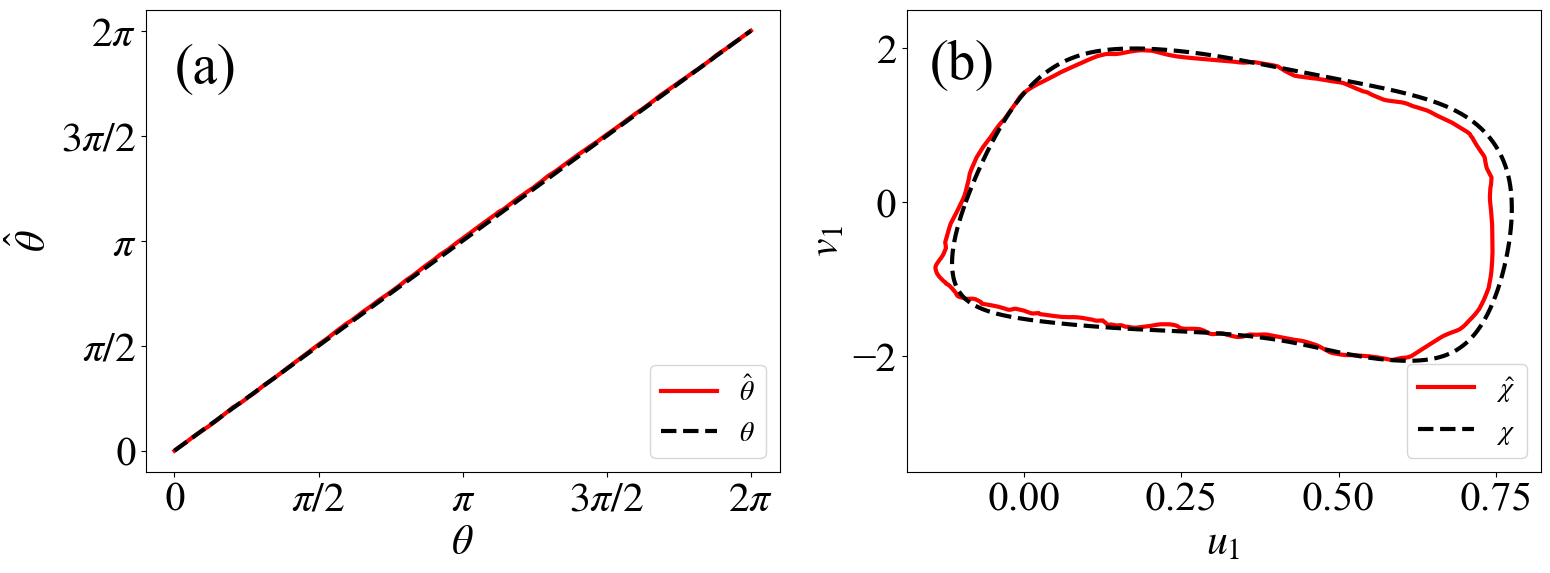

In [6]:
kk = 0

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(a,_ps, color = 'red',label=rf'$\hat \theta$',lw=3)
plt.plot(a,a, color = 'black',linestyle='dashed',label=rf'$\theta$',lw=3)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.yticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.text(0,5.5 ,'(a)',fontsize=40)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\hat{\theta}$')
plt.legend(loc='lower right',fontsize=20)
#plt.plot(a,a, color = 'black')
#plt.plot(a,_ps, color = 'red',linestyle='dashed')
plt.subplot(1,2,2)
plt.plot(eX0[:,kk]*std[kk]+mean[kk],eX0[:,kk+10]*std[kk+10]+mean[kk+10], color = 'red',lw=3,label=r'$\hat \chi$')
plt.plot(X0[:,kk],X0[:,kk+10],color='black',label=r'$\chi$',lw=3,linestyle='--')
plt.text(-0.15,1.6 ,'(b)',fontsize=40)
#plt.xlim(-1.7,1.7)
plt.ylim(-3.5,2.5)
plt.xlabel(r'$u_1$')
plt.ylabel(r'$v_1$')
plt.legend(loc = 'lower right',fontsize=20)

plt.savefig(f'../figure/FHRN_LC.pdf', bbox_inches='tight')
plt.show()

[[-1.2862822084885086, -1.2851084400024964, -0.9611021780111975, -0.5173885240859281, 0.021988376879616713, 0.687067439845915, 1.5136949928000996, 1.4575677753548946, 0.7215336849678881, -0.33966509530643924, 0.32707272135441584, -0.5528705569449612, -0.7332511459203966, -0.8073438497489684, -0.8556590839627576, -1.0226939165860658, -0.658706518281016, 1.0144474819926206, 1.4335898903214395, 1.7155781986460337]]
2.0178070068359375


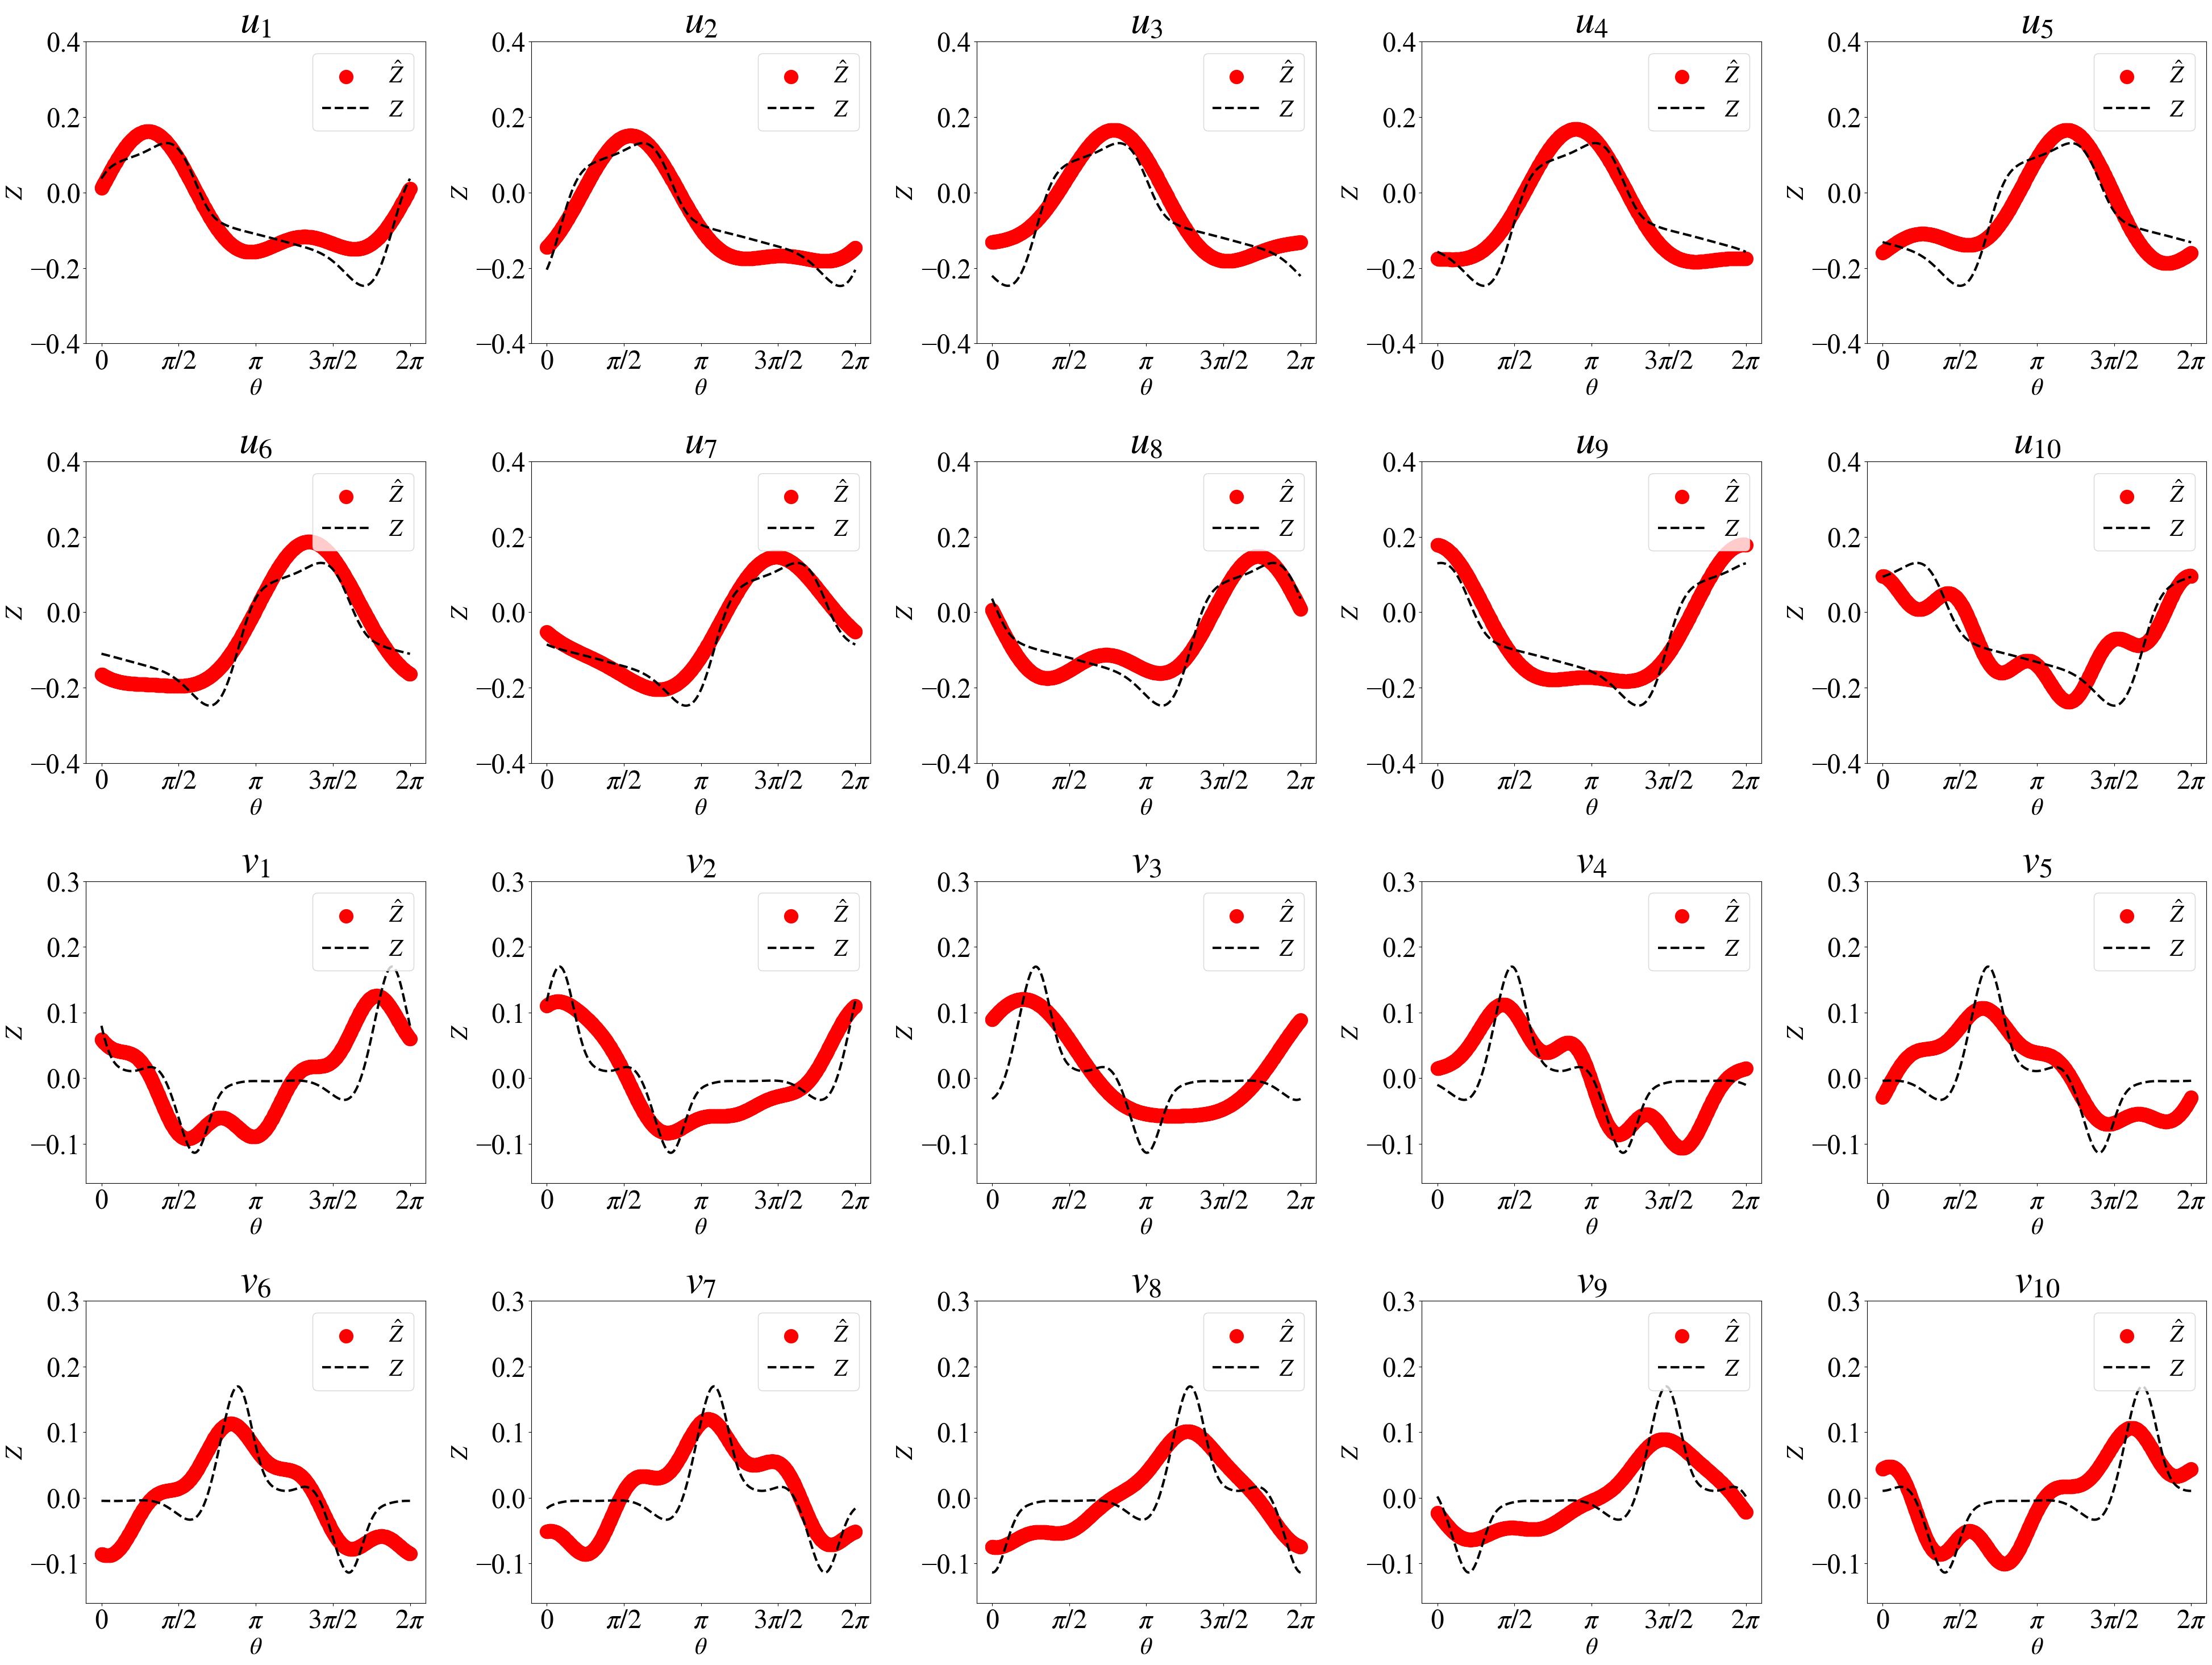

In [7]:
xxx = [rf'$u_{i}$' for i in range(1,10)] + [r'$u_{10}$'] + [rf'$v_{i}$' for i in range(1,10)] + [r'$v_{10}$']


x = [[(X0[0,i]-mean[i])/std[i] for i in range(len(mean))]]
print(x)
x = torch.Tensor(x).to(device,dtype = torch.float)
x.requires_grad = True
z = enc(x)
p0 = to_polar(enc(x)[:,:2]).item()
print(p0)

grad = []
nnn = 1000
for theta in np.linspace(0,2*np.pi,nnn):
    if w>0:
        _x = [[np.cos(theta+p0),np.sin(theta+p0),0]]
    else:
        _x = [[np.cos(-theta+p0),np.sin(-theta+p0),0]]
    _x = torch.Tensor(_x).to(device,dtype = torch.float)
    _x = dec(_x).detach().to('cpu').numpy()[0]
    _x = [_x[i] for i in range(len(_x))]
    #x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor([_x]).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

plt.figure(figsize=(40,30))
xx  = np.linspace(0,2*np.pi,nnn)
for k in range(Z0.shape[1]):
    plt.subplot(4,5,k+1)
    plt.tight_layout()
    plt.title(rf'{xxx[k]}', fontsize=50)
    window = 21 # 移動平均の範囲
    ww = np.ones(window)/window
    if w>0:
        vvv = np.array([grad[i][k]/std[k] for i in range(nnn)])
        vvv = [np.mean(vvv[i*1:(i+1)*1]) for i in range(1000)]
        xxxx = [np.mean(xx[i*1:(i+1)*1]) for i in range(1000)]
        fft_result = np.fft.fft(vvv)
        frequencies = np.fft.fftfreq(len(xxxx), xxxx[1] - xxxx[0])
        NNN = 5  # 上位N個の周波数成分
        fft_result_filtered = np.zeros_like(fft_result)
        fft_result_filtered[np.argsort(np.abs(fft_result))[::-1][:NNN]] = fft_result[np.argsort(np.abs(fft_result))[::-1][:NNN]]
        y_approx = np.fft.ifft(fft_result_filtered).real


        p = np.polyfit(xxxx, vvv, 5)
        y_poly = np.polyval(p, xxxx)
        #plt.scatter(xxxx,vvv,color='red',label=rf'$\hat Z$',lw=4,s=50)
        #print(len(vvv))
        #F = np.fft.fft(vvv)
        #F[:40] = 0
        #f2 = np.fft.ifft(F)
        plt.scatter(xxxx,y_approx,color='red',label=rf'$\hat Z$',lw=4,s=200)
    else:
        plt.plot(xx,[-grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z$',lw=3)
    if k<10:
        plt.ylim(-0.4,0.4)
    else:
        plt.ylim(-0.16,0.3)
    plt.plot(np.linspace(0,2*np.pi,Z0.shape[0]),Z0[:,k],color='black',linestyle='--',label=rf'$Z$',lw=3)
    plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.xlabel(r'$\theta$',fontsize=30)
    plt.ylabel(r'$Z$')
    plt.legend(loc='upper right',fontsize=30)
    plt.tick_params(labelsize=35)
    #plt.savefig(f'Z{model}_x{k+1}.png', bbox_inches='tight')
#plt.savefig(f'Z{model}_x{k+1}.png', bbox_inches='tight')
plt.savefig(f'../figure/CO_PSF3.png', bbox_inches='tight')
plt.show()